## FEDn API Example

This notebook provides an example of how to use the FEDn API to organize experiments and to analyze validation results. We will here run one training session using FedAvg and one session using FedAdam and compare the results.

When you start this tutorial you should have a deployed FEDn Network up and running, and you should have created the compute package and the initial model, see the README for instructions.

In [3]:
from fedn import APIClient
from fedn.dashboard.plots import Plot
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [4]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Initialize FEDn with the compute package and seed model. Note that these files needs to be created separately by follwing instructions in the README.

In [5]:
client.set_package('package.tgz', 'numpyhelper')
client.set_initial_model('seed.npz')
seed_model = client.get_initial_model()

Next we start a training session using FedAvg:

In [13]:
session_config_fedavg = {
                    "helper": "numpyhelper",
                    "session_id": "experiment_fedavg",
                    "aggregator": "fedavg",
                    "model_id": seed_model['model_id'],
                    "rounds": 10
                 }

result_fedavg = client.start_session(**session_config_fedavg)

Wait until the session finished. Then run a session using FedAdam:

In [7]:
session_config_fedopt = {
                    "helper": "numpyhelper",
                    "session_id": "experiment_fedopt",
                    "aggregator": "fedopt",
                    "model_id": seed_model['model_id'],
                    "rounds": 10
                 }

result_fedopt = client.start_session(**session_config_fedopt)

Next, we retrive all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients

In [20]:
models = client.list_models(session_id = "experiment_fedavg")

validations = []
acc = collections.OrderedDict()
for model in models["result"]:
    model_id = model["model"]
    validations = client.list_validations(modelId=model_id)

    for _ , validation in validations.items(): 
        metrics = json.loads(validation['data'])
        try:
            acc[model_id].append(metrics['training_accuracy'])
        except KeyError: 
            acc[model_id] = [metrics['training_accuracy']]
            
mean_acc_fedavg = []
for model, data in acc.items():
    mean_acc_fedavg.append(np.mean(data))
mean_acc_fedavg.reverse()

In [11]:
models = client.list_models(session_id = "experiment_fedopt")

validations = []
acc = collections.OrderedDict()
for model in models["result"]:
    model_id = model["model"]
    validations = client.list_validations(modelId=model_id)
    for _ , validation in validations.items(): 
        metrics = json.loads(validation['data'])
        try:
            acc[model_id].append(metrics['training_accuracy'])
        except KeyError: 
            acc[model_id] = [metrics['training_accuracy']]
            
mean_acc_fedopt = []
for model, data in acc.items():
    mean_acc_fedopt.append(np.mean(data))
mean_acc_fedopt.reverse()

Finally, plot the resulting accuracy

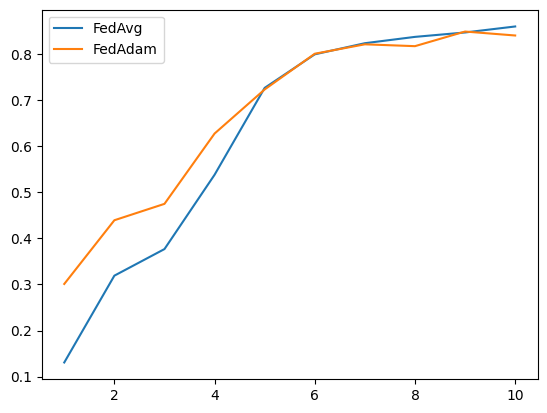

In [22]:
x = range(1,len(mean_acc_fedavg)+1)
plt.plot(x, mean_acc_fedavg, x, mean_acc_fedopt)
plt.legend(['FedAvg', 'FedAdam'])